The game Drop-7 was created by Zynga, and is available in the App Store.
(Play it a few times to appreciate what follows better.)
https://itunes.apple.com/us/app/drop7/id425242132?mt=8


The reinforcement learning aspects of this notebook is adapted from:
https://github.com/JannesKlaas/sometimes_deep_sometimes_learning/blob/master/reinforcement.ipynb




### Logic used in Updating Grid

    init_grid()
    for each row, calculate explosions (but don't execute them)
    for each col, caluclate explosions (but don't execute them)
    EXECUTE ALL THE EXPLOSIONS AT ONCE.
    Grid has been updated.
    Now, Gravity to each of the columns.
    Rinse and repeat!

### Logic used in the Game Loop


    init_grid()
    
    while not game_over:
        update_grid()
        generate_next_ball() # this where all the strategy comes in
        get_column()
        drop_ball_in_column()
    


In [1]:
import numpy as np
import random
import scipy

import cfg
from grid_utils import *
from generate_game import *
from game_strategy import *
from game_log import *


In [2]:
%matplotlib inline

In [3]:
def recreate_grid(size=cfg._SIZE):
    grid = grid_of_zeros(size)
    grid = row(grid, 0, '4143836')
    grid = row(grid, 1,'7131352')
    grid = row(grid, 2,'6260800')
    #list('52134335')
    return grid
    #zecol(3)

In [44]:
def play(s, _outfile):
    
    
    #s = _Stats
    s.reset(_outfile)
    game_over = False
    col = 0
    #grid = recreate_grid()
    grid = generate_init_grid(cfg._SIZE)
    
    
    while not game_over:
        s.ball_drop() #stats
        need_another_col = True
        grid = update_grid(grid, s)
        if s.ball_count % cfg._BALLS_TO_LEVELUP == 0:
            s.level_up()
            print(grid, s.ball_count, file=open(_outfile, "a"))
            print("LEVEL UP", file=open(_outfile, "a"))
            grid, game_over = level_up(grid)
            print(grid, s.ball_count, file=open(_outfile, "a"))
            if game_over:
                break
            grid = update_grid(grid, s) #update grid after Leveling up
            
        print("NZ", nz(grid), file=open(_outfile, "a"))
        s.update_nz(nz(grid))
        
        ball = generate_next_ball(cfg._SIZE)
        print("Ball is ", ball, "column is", col, "nz", nz(grid), file=open(_outfile, "a"))
        
        while need_another_col:
            col = get_column_to_drop_ball(grid, ball) #All the game strategy is in this function
            grid, game_over, need_another_col = drop_ball_in_column(grid, col, ball)
            
        _endisplay = show_grid(grid)
        if _endisplay:
            game_over = True
        
    print_game_over(grid, s)


In [45]:
import sys
import time
#Python image libarary for rendering
from PIL import Image
from IPython import display
from matplotlib import colors

#last frame time keeps track of which frame we are at
last_frame_time = 0


def display_screen(grid):
    #Function used to render the game screen
    #Get the last rendered frame
    global last_frame_time
    

    
    # make a color map of fixed colors
    cmap = colors.ListedColormap(['white', 'green', 'yellow', 'orange', 'red','purple', 'lightblue', 'blue'])
    bounds=[0,1,2,3,4,5,6,7,8] #where to separate the colors
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.imshow(grid.reshape((cfg._SIZE,)*2),
               interpolation='none', cmap=cmap, norm=norm)
    

    #And display the rendering
    display.display(plt.gcf()) #get current figure and display it to any front-end

    #Clear whatever we rendered before
    display.clear_output(wait=True) #Wait to clear the output until new output is available to replace it.

    #Update the last frame time
    last_frame_time = set_max_fps(last_frame_time, 0.5)
    

    
def set_max_fps(last_frame_time, FPS = 1):
    current_milli_time = lambda: int(round(time.time() * 1000))
    remaining_sleep_time = 1./FPS - (current_milli_time() - last_frame_time)/1000.
    if remaining_sleep_time > 0:
        time.sleep(remaining_sleep_time)
    return current_milli_time()


def show_grid(grid):

    try:
        display_screen(grid)
    except KeyboardInterrupt:
        #break
        return 1
        #sys.exit(0)
            
    return 0

GAME OVER
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [5 0 0 0 0 0 0]
 [6 0 1 6 0 4 3]
 [6 0 1 6 3 6 4]]
12
DONE
4 0 39
Wall time: 6.2 s


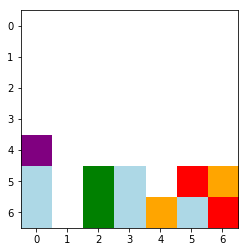

In [46]:
%%time
from game_log import _Stats
s = _Stats
play(s, cfg._outfile)

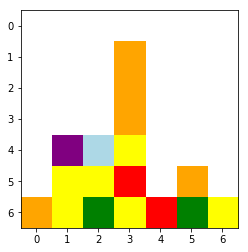

In [35]:
grid = generate_init_grid(7)
show_grid(grid)
grid, game_over, need_another_col = drop_ball_in_column(ball=3, col=3, grid=grid)
show_grid(grid)
grid, game_over, need_another_col = drop_ball_in_column(ball=3, col=3, grid=grid)
show_grid(grid)
grid, game_over, need_another_col = drop_ball_in_column(ball=3, col=3, grid=grid)
show_grid(grid)

In [ ]:
pd.Series(s.nz).plot()
pd.Series(s.ptslist).cumsum().plot()


In [ ]:
grid

In [ ]:
vec = [7,2,3,4,4,5,6]
inplace_explosions(vec)

[531...
[

In [ ]:
vec = [0, 0, 0, 4, 7, 4, 7]
vec = [4, 1, 4, 3, 7, 7, 2]

vec = [int(x) for x in list('4327147')]
#apply_explosions_to_line(vec, HORIZ)
update_line(vec, 1)

In [ ]:
generate_init_grid(4)


In [ ]:
class Drop7(object):
    """
    Class Drop7 is the actual game.
    
    
    """
    def __init__(self, grid_size=7):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]
        
    def get_state(self):
        return self.state

In [ ]:
class Catch(object):
    """
    Class Catch is the actual game.
    
    
    """
    def __init__(self, grid_size=7):
        self.grid_size = grid_size
        self.reset() # redraws the grid...

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        
        This is typically called by act().
        """
        state = self.state
        print("state before action", self.state)
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        fr, fc, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        fr += 1 #ball drops down
        out = np.asarray([fr, fc, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas
        
    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        print(self.state[0])
        # only the final action (catch or drop the ball) gets a nonzero reward
        if fruit_row == self.grid_size-1: 
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1) #column of the Ball
        m = np.random.randint(1, self.grid_size-2, size=1) # column of Basket center
        self.state = np.asarray([0, n, m])[np.newaxis]
        
    def get_state(self):
        return self.state

In [ ]:
env = Drop7()
env.get_state()

In [ ]:
# Define environment/game
grid_size = 7
env = Drop7(grid_size)

In [ ]:
env.reset()

In [ ]:
env.observe()

In [ ]:
env._draw_state()

In [ ]:
env.reset()

In [ ]:
env.act(-1)
env._draw_state()
env.get_state(), env._get_reward()


In [ ]:
env.observe()

In [ ]:
env.get_state()[0,1]

In [ ]:
c

In [ ]:
state =  np.asarray([0, 1, 2])[np.newaxis]

In [ ]:
np.asarray([1,1,1]).shape, np.asarray([1,1,1])[np.newaxis][np.newaxis].shape

In [ ]:
state[0,1]

In [ ]:
grid_size=7
im_size = (grid_size,)*2
grid = np.zeros(im_size)
grid

In [ ]:
grid[:,2]

In [ ]:
grid[2]  = 3

In [ ]:
grid[:,2] = 4

In [ ]:
grid[6,6] = 6

In [ ]:
#temp =  grid[:,1][:-1]
im = (7,7)
a = np.zeros(im)
temp = a[1:, 3]
a

In [ ]:
temp

In [ ]:
temp = grid[:,3][:-1].copy()

In [ ]:
temp

In [ ]:
grid[:, 3] = np.zeros(7)

In [ ]:
grid[1:, 1] = temp

In [ ]:
temp

In [ ]:
temp = np.array([1,0,3, 0, 1])
list(zip(temp[:-1], temp[1:]))

In [ ]:
grid.shape[1]

In [ ]:
for col in g.shape[1]:
    #print(g[:,col])
    g[:, col] = apply_gravity_to_column(g[:, col])

print(g)

In [ ]:
temp[0], temp[1] = temp[1], temp[0]

In [ ]:
temp

In [ ]:
# this is not being used
def update_line(vec, colflag=True):
    '''
    Apply explosions and Gravity
    Calculate points
    '''
    something_changed = True
    safety_brkr =0
    updated = vec[:]
    while something_changed:        
        something_changed = False
        safety_brkr += 1
        # print(safety_brkr)
                
        change, _, updated = inplace_explosions(updated)
        if(change):
            something_changed = True

        if(colflag):
            change, _, updated = apply_gravity_to_column(updated)
            if(change):
                something_changed = True


        if safety_brkr == 100:
            print("Safety Circuit Breaker. Something is not right")
            break
            
        
    return updated
    